# Plasmonic cavity resonator consisting of a gold nanorod array

Plasmonic structures have been under intense research interest in the past few decades, primarily because of their unique ability to confine light to subwavelength dimensions, significantly enhancing electromagnetic fields at their surfaces. This phenomenon has opened up new avenues in various scientific fields, including photovoltaics, sensing, and nanoscale imaging, by enabling the manipulation of light at the nanometer scale. 

In this notebook, we demonstrate the modeling of a hexagonal lattice of gold nanorods, which supports localized surface plasmon resonances. When excited by a plane wave, these resonances manifest as distinct dips in the reflectance spectrum, indicative of the efficient transfer of incident power into the plasmon modes. Through the examination of field profiles at these resonance points, it becomes possible to discern the standing waves correlating to various harmonics. The design is adopted from `David P. Lyvers, Jeong-Mi Moon, Alexander V. Kildishev, Vladimir M. Shalaev, and Alexander Wei, ACS Nano 2008, 2, 12, 2569–2576` [DOI: 10.1021/nn8006477](https://doi.org/10.1021/nn8006477).

<img src="img/nanorod_array.png" width="400" alt="Schematic of the nanorod array">

This notebook mainly aims to demonstrate how to model a hexagonal lattice within the FDTD simulation domain, which is rectangular. In addition, the plane wave source in `Tidy3D` by default has an incident power of 1 W. In this example, we also demonstrate how to perform field normalization to obtain a meaningful relative field enhancement factor. For more discussion on source normalization, refer to the [FAQ entry](https://www.flexcompute.com/tidy3d/learning-center/faq/#how-are-results-normalized).

Periodic or quasi-periodic structures are common in photonic devices. In Tidy3D's example library, we have demonstrated a [gradient metasurface reflector](https://www.flexcompute.com/tidy3d/examples/notebooks/GradientMetasurfaceReflector/), a [metalens at the visible frequency](https://www.flexcompute.com/tidy3d/examples/notebooks/Metalens/), and a [graphene metamaterial absorber](https://www.flexcompute.com/tidy3d/examples/notebooks/GrapheneMetamaterial/). In addition, we also investigated a [frequency selected surface](https://www.flexcompute.com/tidy3d/examples/notebooks/MicrowaveFrequencySelectiveSurface/) for the microwave frequency range.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tidy3d as td
import tidy3d.web as web

## Simulation Setup

Define the simulation wavelength (frequency) range.

In [2]:
lda0 = 1.15  # central wavelength
freq0 = td.C_0 / lda0  # central frequency
ldas = np.linspace(0.4, 1.9, 201)  # wavelength range
freqs = td.C_0 / ldas  # frequency range
fwidth = 0.5 * (np.max(freqs) - np.min(freqs))  # width of the source frequency range

Define the geometric parameters for the nanorod array. 

In [3]:
h = 0.649  # height of the nanorods
a = 0.098  # spacing between the nanorods
d = 0.0636  # diameter of the nanorods
t_base = 0.05  # thickness of the base plate

Define the materials used in the simulation. Tidy3D's material library provides several options for gold. In this particular case, we will use the data from the widely used [paper](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.6.4370) by Johnson and Christy in 1972. 

The Al$_2$O$_3$ is defined by a constant refractive index material in the wavelength range of interest.

In [4]:
# define gold material from the material library
gold = td.material_library["Au"]["JohnsonChristy1972"]

# define Al2O3 material as a constant refractive index
n_eff = 1.61  # refractive index of Al2O3
al2o3 = td.Medium(permittivity=n_eff**2)

Next we define the structures, which include the dielectric filling, two nanorods, and a base plate. 

The nanorods are arranged in a hexagonal lattice. In FDTD, the simulation domain needs to be rectangular. For a hexagonal lattice, we can identify a rectangular unit cell as indicated by the blue dashed box below. For a plane wave excitation, we can apply periodic boundary conditions for normal incidence or Bloch boundary conditions for oblique incidence. 

In addition, we notice that the unit cell structure has two reflection symmetries. Therefore, in the case of normal incidence of a plane wave linearly polarized either in the horizontal or vertical directions, we can utilize the symmetry to further reduce the simulation domain size by a factor of 4. For more details on symmetry, please refer to the tutorial [here](https://www.flexcompute.com/tidy3d/examples/notebooks/Symmetry/). Next we are going to take this approach and only model the unit cell.

<img src="img/hexagonal_lattice.png" width="400" alt="Schematic of the unit cells in a haxagonal lattice">

In [5]:
# define the Al2O3 filling structure
dielectric = td.Structure(
    geometry=td.Box(center=(0, 0, h / 2), size=(td.inf, td.inf, h)), medium=al2o3
)

# define the first nanorod structure
rod_1 = td.Structure(
    geometry=td.Cylinder(center=(0, 0, h / 2), radius=d / 2, length=h), medium=gold
)

# define the second nanorod structure
rod_2 = td.Structure(
    geometry=td.Cylinder(center=(a / 2, np.sqrt(3) * a / 2, h / 2), radius=d / 2, length=h),
    medium=gold,
)

# define the third nanorod structure
rod_3 = td.Structure(
    geometry=td.Cylinder(center=(a / 2, -np.sqrt(3) * a / 2, h / 2), radius=d / 2, length=h),
    medium=gold,
)

# define the forth nanorod structure
rod_4 = td.Structure(
    geometry=td.Cylinder(center=(-a / 2, np.sqrt(3) * a / 2, h / 2), radius=d / 2, length=h),
    medium=gold,
)

# define the fifth nanorod structure
rod_5 = td.Structure(
    geometry=td.Cylinder(center=(-a / 2, -np.sqrt(3) * a / 2, h / 2), radius=d / 2, length=h),
    medium=gold,
)

# define the base plate structure
base = td.Structure(
    geometry=td.Box(center=(0, 0, -t_base / 2), size=(td.inf, td.inf, t_base)), medium=gold
)

Next we define the source and monitors. A [PlaneWave](../api/_autosummary/tidy3d.PlaneWave.html) polarized in the $y$ direction is injected from the top of the nanorods. By default the plane wave is polarized in the $x$ direction. To make it $y$-polarized, we set `pol_angle` to $\pi$/2.

To measure reflection, we define a [FluxMonitor](../api/_autosummary/tidy3d.FluxMonitor.html) above the [PlaneWave](../api/_autosummary/tidy3d.PlaneWave.html). In addition, we define a [FieldMonitor](../api/_autosummary/tidy3d.FieldMonitor.html) to help visualize the field profiles at the resonances. In principle, one needs to run the simulation first without the [FieldMonitor](../api/_autosummary/tidy3d.FieldMonitor.html) to determine the resonance wavelengths (frequencies) and then rerun it with the [FieldMonitor](../api/_autosummary/tidy3d.FieldMonitor.html) set to record the resonance frequencies. For presentation purposes, the resonance wavelengths (frequencies) are pre-determined here.

In [6]:
# define a plane wave incident on the nanorod array from the top
plane_wave = td.PlaneWave(
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    size=(td.inf, td.inf, 0),
    center=(0, 0, h + 0.4 * lda0),
    direction="-",
    pol_angle=np.pi / 2,
)

# define a flux monitor above the plane wave to measure reflection
flux_monitor = td.FluxMonitor(
    center=[0, 0, h + 0.5 * lda0], size=[td.inf, td.inf, 0], freqs=freqs, name="R"
)

# pre-determined resonance wavelengths
res_ldas = np.array([1.6, 1.25, 0.93, 0.765, 0.675])
# corresponding resonance frequencies
res_freqs = td.C_0 / res_ldas

# define a field monitor at the resonance frequencies to visualize the excited modes
monitor_field = td.FieldMonitor(
    center=[a / 4, a * np.sqrt(3) / 4, h / 2],
    size=[0, a * np.sqrt(3) / 2, 2 * h],
    freqs=res_freqs,
    name="field",
)

With everything in place, we are ready to define the [Simulation](../api/_autosummary/tidy3d.Simulation.html). Since the simulation domain is very small, we can afford to use a very fine grid without increasing the cost. In this case, we use an automatic nonuniform grid with a minimum steps per wavelength of 80. 

For the boundary condition, we apply the periodic boundary condition in the $x$ and $y$ directions and PML in the $z$ direction. `symmetry=(1,-1,0)` is used since the incident light is polarized in the $y$ direction.

The default automatic shutoff level is `1e-5` but we decreased it to `1e-7` to further enhance the simulation accuracy, which is typically not required. It can be needed in simulations like plasmonics where strong fields are concentrated in relatively small volumes.

In [7]:
run_time = 2e-13  # simulation run time

# define simulation domain size
sim_size = (a, np.sqrt(3) * a, 1.5 * lda0 + h)

# set up simulation
sim = td.Simulation(
    center=(0, 0, h / 2),
    size=sim_size,
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=80, wavelength=lda0),
    structures=[dielectric, base, rod_1, rod_2, rod_3, rod_4, rod_5],
    sources=[plane_wave],
    monitors=[flux_monitor, monitor_field],
    run_time=run_time,
    boundary_spec=td.BoundarySpec(
        x=td.Boundary.periodic(), y=td.Boundary.periodic(), z=td.Boundary.pml()
    ), 
    symmetry=(1, -1, 0),
    shutoff=1e-7,  # reducing the default shutoff level
)

After the simulation is set up, we can inspect the structure and grid to ensure the setup is correct and the grid is sufficiently fine.

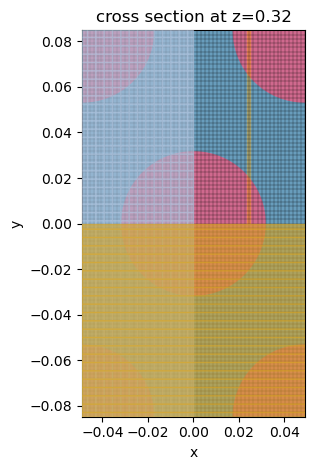

In [8]:
ax = sim.plot(z=h / 2)
sim.plot_grid(z=h / 2, ax=ax)
plt.show()

Also plot the 3D visualization.

In [9]:
sim.plot_3d()

## Run Simulation

Now we are ready to submit the simulation to the server.

In [10]:
sim_data = web.run(simulation=sim, task_name="nanorod_array")

10:13:08 Eastern Standard Time Created task 'nanorod_array' with task_id        
                               'fdve-a32680fd-2fdc-47f2-b738-8854615b5f43' and  
                               task_type 'FDTD'.

                               View task using web UI at                        
                               ]8;id=786447;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a32680fd-2fdc-47f2-b738-8854615b5f43\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=688076;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a32680fd-2fdc-47f2-b738-8854615b5f43\taskId]8;;\
                               ]8;id=786447;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a32680fd-2fdc-47f2-b738-8854615b5f43\=]8;;\]8;id=77038;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a32680fd-2fdc-47f2-b738-8854615b5f43\fdve]8;;\]8;id=786447;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a32680fd-2fdc-47f2-b738-8854615b5f43\-a32680fd-2fdc-47f2-b738-8854615b5f43']8;;\.

Output()

10:13:10 Eastern Standard Time status = queued

Output()

10:13:26 Eastern Standard Time status = preprocess

10:13:30 Eastern Standard Time Maximum FlexCredit cost: 0.031. Use              
                               'web.real_cost(task_id)' to get the billed       
                               FlexCredit cost after a simulation run.

                               starting up solver

                               running solver

                               To cancel the simulation, use                    
                               'web.abort(task_id)' or 'web.delete(task_id)' or 
                               abort/delete the task in the web UI. Terminating 
                               the Python script will not stop the job running  
                               on the cloud.

Output()

10:13:52 Eastern Standard Time early shutoff detected at 64%, exiting.

                               status = postprocess

Output()

10:13:57 Eastern Standard Time status = success

                               View simulation result at                        
                               ]8;id=985069;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a32680fd-2fdc-47f2-b738-8854615b5f43\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=147699;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a32680fd-2fdc-47f2-b738-8854615b5f43\taskId]8;;\
                               ]8;id=985069;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a32680fd-2fdc-47f2-b738-8854615b5f43\=]8;;\]8;id=883969;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a32680fd-2fdc-47f2-b738-8854615b5f43\fdve]8;;\]8;id=985069;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a32680fd-2fdc-47f2-b738-8854615b5f43\-a32680fd-2fdc-47f2-b738-8854615b5f43']8;;\.

Output()

10:13:59 Eastern Standard Time loading simulation from simulation_data.hdf5

## Postprocessing and Result Visualization

Since the simulation domain is quite small, the simulation took less than a minute to finish. First, we plot the reflectance spectrum. Vertical lines are added to indicate the resonance wavelengths. At resonance, the incident wave excites the plasmon modes and thus the reflection is suppressed.

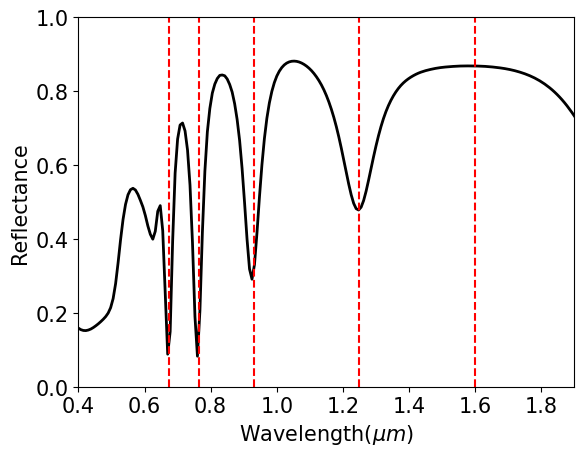

In [11]:
R = sim_data["R"].flux  # extract reflectance

# plotting
plt.plot(ldas, R, c="black", linewidth=2)

# adding vertical lines at the resonances
for res_lda in res_ldas:
    plt.axvline(x=res_lda, linestyle="--", c="red")

plt.xlim(min(ldas), max(ldas))
plt.ylim(0, 1)
plt.xlabel("Wavelength($\mu m$)", fontsize=15)
plt.ylabel("Reflectance", fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.show()

Finally, plot the field profiles at the resonance wavelengths. In particular, we plot the absolute value of $E_y$. Here we can clearly observe the standing wave patterns with increasing orders between the rods, consistent with the result presented in Figure 4 of the [original publication](https://doi.org/10.1021/nn8006477).

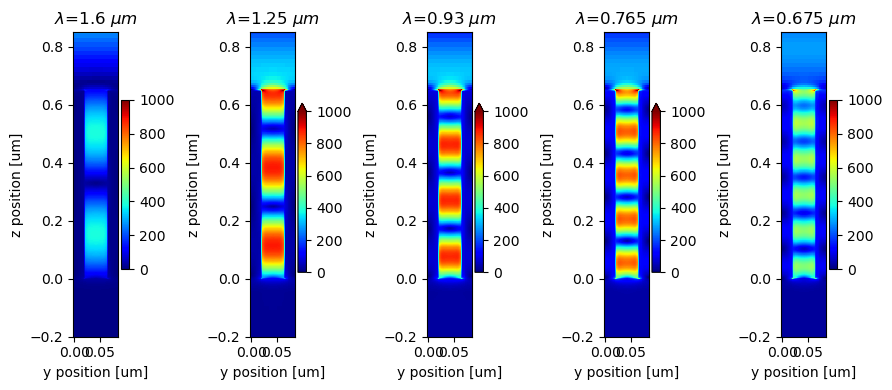

In [12]:
fig, ax = plt.subplots(1, len(res_ldas), figsize=(9, 4), tight_layout=True)
for i, res_freq in enumerate(res_freqs):
    E = np.sqrt(sim_data["field"].intensity.sel(f=res_freq))  # field strength

    # plotting
    E.plot(x="y", y="z", ax=ax[i], vmin=0, vmax=1e3, cmap="jet")
    ax[i].set_title(f"$\lambda$={res_ldas[i]} $\mu m$")
    ax[i].set_ylim(-0.2, h + 0.2)
plt.show()

## Normalization of the Field

Note that in Tidy3D, the plane wave has a constant power of 1 W. Therefore, the field strength scales with the plane size of the source. Very often we want to get the normalized field enhancement relative to the source field strength. To get the source field strength, one can calculate it analytically based on the power and area of the source plane. Alternatively, in a more convenient and accurate way, one can run a reference simulation without any structures and get the incident field strength numerically. Here we demonstrate how to do it.

First we create a reference simulation by copying the previous simulation and updating the structures to an empty list, i.e. no structures. We run the simulation to get the results.

In [13]:
sim_ref = sim.copy(update={"structures": []})

sim_data_ref = web.run(simulation=sim_ref, task_name="reference")

10:14:00 Eastern Standard Time Created task 'reference' with task_id            
                               'fdve-6b95e9c8-7988-4d98-886e-7881dba6d9a1' and  
                               task_type 'FDTD'.

                               View task using web UI at                        
                               ]8;id=721767;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6b95e9c8-7988-4d98-886e-7881dba6d9a1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=826716;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6b95e9c8-7988-4d98-886e-7881dba6d9a1\taskId]8;;\
                               ]8;id=721767;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6b95e9c8-7988-4d98-886e-7881dba6d9a1\=]8;;\]8;id=940149;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6b95e9c8-7988-4d98-886e-7881dba6d9a1\fdve]8;;\]8;id=721767;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6b95e9c8-7988-4d98-886e-7881dba6d9a1\-6b95e9c8-7988-4d98-886e-7881dba6d9a1']8;;\.

Output()

10:14:01 Eastern Standard Time status = queued

Output()

10:14:17 Eastern Standard Time status = preprocess

10:14:20 Eastern Standard Time Maximum FlexCredit cost: 0.025. Use              
                               'web.real_cost(task_id)' to get the billed       
                               FlexCredit cost after a simulation run.

                               starting up solver

10:14:21 Eastern Standard Time running solver

                               To cancel the simulation, use                    
                               'web.abort(task_id)' or 'web.delete(task_id)' or 
                               abort/delete the task in the web UI. Terminating 
                               the Python script will not stop the job running  
                               on the cloud.

Output()

10:14:27 Eastern Standard Time early shutoff detected at 8%, exiting.

                               status = postprocess

Output()

10:14:33 Eastern Standard Time status = success

                               View simulation result at                        
                               ]8;id=983376;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6b95e9c8-7988-4d98-886e-7881dba6d9a1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=400447;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6b95e9c8-7988-4d98-886e-7881dba6d9a1\taskId]8;;\
                               ]8;id=983376;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6b95e9c8-7988-4d98-886e-7881dba6d9a1\=]8;;\]8;id=323579;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6b95e9c8-7988-4d98-886e-7881dba6d9a1\fdve]8;;\]8;id=983376;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6b95e9c8-7988-4d98-886e-7881dba6d9a1\-6b95e9c8-7988-4d98-886e-7881dba6d9a1']8;;\.

Output()

10:14:34 Eastern Standard Time loading simulation from simulation_data.hdf5

After getting the results, we can inspect it a bit. Since the incident plane wave is polarized in the $y$ direction, let's see the absolute value of $E_y$ at $z$=0. As expected, the field strength is a constant.

In [14]:
sim_data_ref["field"].Ey.abs.sel(f=res_freqs[-1], z=0, method="nearest")

<xarray.ScalarFieldDataArray (x: 1, y: 8)>
array([[214.05777, 214.05777, 214.05777, 214.05777, 214.05777, 214.05774,
        214.05777, 214.05777]], dtype=float32)
Coordinates:
  * x        (x) float64 0.0245
  * y        (y) float64 -0.01415 0.0 0.01415 ... 0.05658 0.07073 0.08487
    z        float64 -0.004428
    f        float64 4.441e+14
Attributes:
    long_name:  field value

Now we can normalize the field in the previous plot by the incident field strength and plot it again.

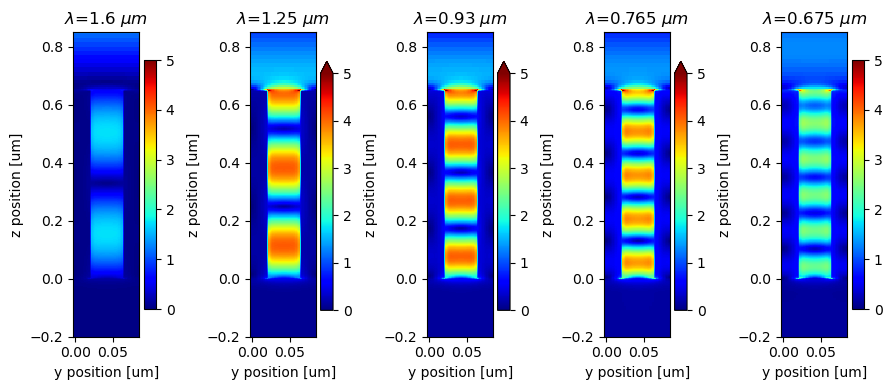

In [15]:
fig, ax = plt.subplots(1, len(res_ldas), figsize=(9, 4), tight_layout=True)
for i, res_freq in enumerate(res_freqs):
    E_sim = np.sqrt(sim_data["field"].intensity.sel(f=res_freq))  # simulated field strength
    E_ref = (
        sim_data_ref["field"].Ey.abs.sel(f=res_freq, z=0, y=0, method="nearest").values[0]
    )  # incident field strength
    E_norm = E_sim / E_ref  # normalization

    # plotting field profiles
    E_norm.plot(x="y", y="z", ax=ax[i], vmin=0, vmax=5, cmap="jet")
    ax[i].set_title(f"$\lambda$={res_ldas[i]} $\mu m$")
    ax[i].set_ylim(-0.2, h + 0.2)
plt.show()

Just as a check, we can calculate the incident field strength by $|E|= (2P/(c_0 \varepsilon_0 A))^{1/2}$, where $\varepsilon_0$ is the vacuum permittivity, $c_0$ is the speed of light, $A$ is the area of the source plane, and $P$ is the source power. 

As we can see, the result from this calculation is very close to the field strength from the previous reference simulation.

In [16]:
P = 1  # incident power is 1 W
A = a * np.sqrt(3) * a  # source plane area in um^2
E_ref = np.sqrt(2 * P / (td.C_0 * td.EPSILON_0 * A))
print(f"The calculated incident field strength is {E_ref:.2f} V/um.")

The calculated incident field strength is 212.83 V/um.
